In [1]:
from gym_minigrid.wrappers import *
from gym_minigrid.minigrid import *
import gym

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.evaluation import evaluate_policy

import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
%matplotlib notebook

# Create custom enviroment

Environment where ball and agent are randomly put into square grid. Ball color and grid size can be changed.

In [2]:
class EmptyBallRoom(MiniGridEnv):
    def __init__(self, size=5, ball_color="green"):
        self.ball_color = ball_color
        super().__init__(
            grid_size=size,
            max_steps=4*size*size,
            # Set this to True for maximum speed
            see_through_walls=True
        )
    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Place the agent
        # self.agent_pos = (1, 1)
        # self.agent_dir=0
        self.place_agent()
        
        # Place object
        self.ball = Ball(self.ball_color)
        # self.put_obj(self.ball, width-2, height-2)
        self.place_obj(self.ball)
        self.mission = f"Pick up {self.ball_color} {self.ball.type}"
        
    def step(self, action):
        obs, reward, done, info = super().step(action)

        if action == self.actions.pickup:
            if self.carrying and self.carrying == self.ball:
                reward = self._reward()
                done = True

        return obs, reward, done, info

In [3]:
# Function to create the environment (needed for vectorized environment object in training process)
def make_env(ball_color, room_size, rank, seed=0):
    """
    Utility function for multiprocessed env.

    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environments you wish to have in subprocesses
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    def _init():
        env = ImgObsWrapper(RGBImgPartialObsWrapper(EmptyBallRoom(size=16, ball_color=ball_color)))
        #env = gym.make(env_id)
        env.seed(seed + rank)
        return env
    set_random_seed(seed)
    return _init

In [4]:
BALL_COLOR = "green"
ROOM_SIZE = 16

# Reinforcment learning

### Training first agent (not essential to use the trained agent)

In [ ]:
# Number of "cores" to use
N_CPU = 12

In [ ]:
# Create vectorized environment to make learning faster
env = SubprocVecEnv([make_env(ball_color = BALL_COLOR, room_size=ROOM_SIZE, rank=i*2) for i in range(N_CPU)])

In [ ]:
# Activation function to be used in CNN layers
policy_kwargs = dict(activation_fn=nn.ReLU)

In [ ]:
# https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html?highlight=PPO
model = PPO('CnnPolicy', env, policy_kwargs=policy_kwargs, verbose=1)

In [ ]:
model.learn(total_timesteps=2_500_000)

In [ ]:
model.save("rgb_ball_agent")

### Loading trained agent

In [5]:
# To load zip file just enter the file name without the file type in the end
model = PPO.load("rgb_ball_agent", device="cpu")

# Displaying the agent in the enivronment

In [10]:
def display_agent(env,  pov="agent", n_eval=10):
    # Two picturs. Left side = agent's view, right side = whoel environment
    fig,(ax1, ax2) = plt.subplots(1,2, figsize=(10, 5));

    for i in range(n_eval):
        state = env.reset()
        if i == 0:
            image1 = ax1.imshow(state)              
            image2 = ax2.imshow(env.render("rgb_array"))
            
        else:
            image1.set_data(state)
            image2.set_data(env.render("rgb_array"))
        while True:
            action, _ = model.predict(state)
            state, r, done, _ = env.step(action)
            image1.set_data(state)
            image2.set_data(env.render("rgb_array"))
    
            ax1.set_title(f"Action = {action}")
            ax2.set_title(f"Action = {action}")
            fig.canvas.draw()
            if done:
                break

In [11]:
# Make testing environment. Don't use previous vectorized environment (for me it freezed the notebook)
test_env = make_env(ball_color = "green", room_size=20, rank=5)()

<IPython.core.display.Javascript object>


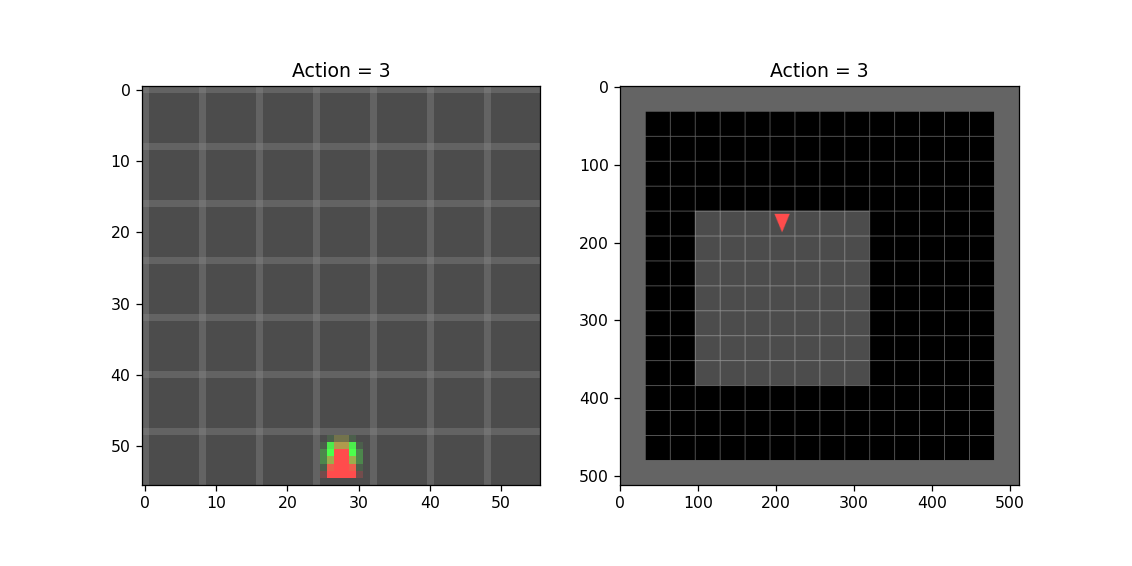

In [13]:
display_agent(test_env)

# 2nd agent

This requires to change our environment. Because stable_baselines3 gets the action indeices from the environment. Look at:
https://github.com/maximecb/gym-minigrid/blob/1d4edcfd585f6b627ebf1cfd54ea5e70260fa1ee/gym_minigrid/minigrid.py#L629

https://github.com/maximecb/gym-minigrid/blob/1d4edcfd585f6b627ebf1cfd54ea5e70260fa1ee/gym_minigrid/minigrid.py#L1099
I think redefining the Actions class and step function should be sufficient.
Possible way is to inherit EmptyBallRoom class because it has correct reward function.